# Chess Data Analysis ♟♞♝♜♛♚

<img src="chess_image.jpeg" style="width: 900px">

By <a href="https://github.com/Lufeva123"> Luiz Valle

This data analysis is aimed at uncovering interesting insights from a dataset containing information about different chess games played on Linchess. This data was drawn from <a href="https://www.kaggle.com/datasnaek/chess"> Kaggle.

# Importing libraries and taking a look at the data

In [73]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [4]:
%matplotlib inline

In [5]:
file_path = "chess_games.csv"
chess_df = pd.read_csv(file_path)
chess_df.head()

,id,rated,created_at,last_move_at,turns,victory_status,winner,increment_code,white_id,white_rating,black_id,black_rating,moves,opening_eco,opening_name,opening_ply
0,TZJHLljE,False,1.504210e+12,1.504210e+12,13,outoftime,white,15+2,bourgris,1500,a-00,1191,d4 d5 c4 c6 cxd5 e6 dxe6 fxe6 Nf3 Bb4+ Nc3 Ba5...,D10,Slav Defense: Exchange Variation,5
1,l1NXvwaE,True,1.504130e+12,1.504130e+12,16,resign,black,5+10,a-00,1322,skinnerua,1261,d4 Nc6 e4 e5 f4 f6 dxe5 fxe5 fxe5 Nxe5 Qd4 Nc6...,B00,Nimzowitsch Defense: Kennedy Variation,4
2,mIICvQHh,True,1.504130e+12,1.504130e+12,61,mate,white,5+10,ischia,1496,a-00,1500,e4 e5 d3 d6 Be3 c6 Be2 b5 Nd2 a5 a4 c5 axb5 Nc...,C20,King's Pawn Game: Leonardis Variation,3
3,kWKvrqYL,True,1.504110e+12,1.504110e+12,61,mate,white,20+0,daniamurashov,1439,adivanov2009,1454,d4 d5 Nf3 Bf5 Nc3 Nf6 Bf4 Ng4 e3 Nc6 Be2 Qd7 O...,D02,Queen's Pawn Game: Zukertort Variation,3
4,9tXo1AUZ,True,1.504030e+12,1.504030e+12,95,mate,white,30+3,nik221107,1523,adivanov2009,1469,e4 e5 Nf3 d6 d4 Nc6 d5 Nb4 a3 Na6 Nc3 Be7 b4 N...,C41,Philidor Defense,5


In [6]:
chess_df.describe()

,created_at,last_move_at,turns,white_rating,black_rating,opening_ply
count,2.005800e+04,2.005800e+04,20058.000000,20058.000000,20058.000000,20058.000000
mean,1.483617e+12,1.483618e+12,60.465999,1596.631868,1588.831987,4.816981
std,2.850151e+10,2.850140e+10,33.570585,291.253376,291.036126,2.797152
min,1.376772e+12,1.376772e+12,1.000000,784.000000,789.000000,1.000000
25%,1.477548e+12,1.477548e+12,37.000000,1398.000000,1391.000000,3.000000
50%,1.496010e+12,1.496010e+12,55.000000,1567.000000,1562.000000,4.000000
75%,1.503170e+12,1.503170e+12,79.000000,1793.000000,1784.000000,6.000000
max,1.504493e+12,1.504494e+12,349.000000,2700.000000,2723.000000,28.000000


# Investigating the relationship between opening choice and game winner

I was interested in knowing whether there is any relationship between the opening used and who wins the game, so I decided to create a bar graph counting how many white wins, draws, and black wins there were for each of the 8 most commonly used openings in the dataset.

In [7]:
# Creating a Pandas DataFrame with the opening name as the index and three columns storing the counts of how many times white and
# black won or drew.
opening_winner_df = pd.DataFrame(columns=["White", "Draw", "Black", "Total"])
chess_opening_groupby = chess_df.groupby("opening_name")
for name, group in chess_opening_groupby:
    white_count = len(group[group["winner"] == "white"])
    draw_count = len(group[group["winner"] == "draw"])
    black_count = len(group[group["winner"] == "black"])
    opening_winner_df.loc[name] = [white_count, draw_count, black_count, white_count + draw_count + black_count]

In [8]:
# Sorting the newly created DataFrame based on the total number of times that each opening was played and taking the fisrt 8 rows.
opening_winner_df.sort_values(by="Total", axis=0, ascending=False, inplace=True)
most_used_openings = opening_winner_df.head(8)
most_used_openings

,White,Draw,Black,Total
Van't Kruijs Opening,126,16,226,368
Sicilian Defense,149,15,194,358
Sicilian Defense: Bowdler Attack,119,13,164,296
Scotch Game,145,11,115,271
French Defense: Knight Variation,135,15,121,271
Scandinavian Defense: Mieses-Kotroc Variation,164,6,89,259
Queen's Pawn Game: Mason Attack,116,13,103,232
Queen's Pawn Game: Chigorin Variation,112,8,109,229


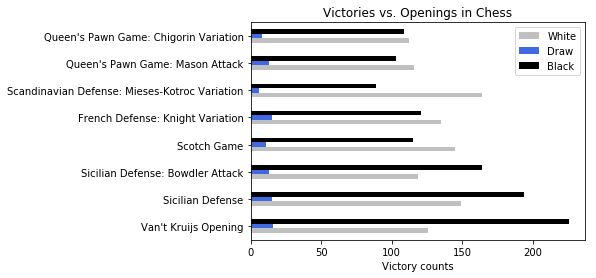

In [9]:
ax = most_used_openings[["White", "Draw", "Black"]].plot.barh(rot=0, color=["silver", "royalblue", "black"], stacked=False)
plt.title("Victories vs. Openings in Chess")
plt.xlabel("Victory counts")
plt.show()

One interesting thing to note is that the Van't Kruijs Opening (1.e3), considered and unorthodox opening, is the most widely used in this dataset and it results in more black wins. I would like to investigate this further by seeing which players are using this opening. Also, it seems that with the three most used openings, black won most of the time, intriguing given the fact that white has the first move.

# Van't Kruijs Opening

In [10]:
#Extract a DataFrame containing the ratings of the players in games that opened with Van't Kruijs
vant_kruijs_and_rating = chess_opening_groupby.get_group("Van't Kruijs Opening")[["white_rating", "black_rating"]]
#Get the mean white rating and mean black rating
white_mean = vant_kruijs_and_rating["white_rating"].mean()
black_mean = vant_kruijs_and_rating["black_rating"].mean()

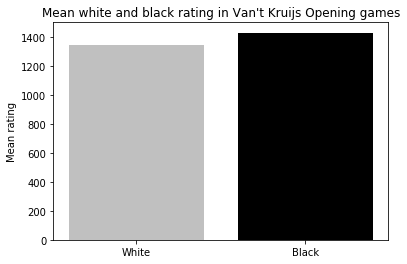

In [11]:
#Plot result as a graph
plt.bar(np.arange(2), [white_mean, black_mean], align="center", color=["silver", "black"])
plt.title("Mean white and black rating in Van't Kruijs Opening games")
plt.xticks(np.arange(2), ["White", "Black"])
plt.ylabel("Mean rating")
plt.show()

The mean rating for both white and black is in the range 1200-1400, which is generally considered a beginner or mid-level player. This might suggest that this unusual opening was played due to inexperience. Also, It seems that the mean player rating for black is slightly higher than that for white, but the difference is so small that it is probably not significant. This and the fact that black won much more often than white when this opening was played may suggest that the Van't Kruijs Opening put white players at an early disadvantage that was hard to recover from given the smilarity in ratings.
I would like now to take a look at what opening is preferred by players of level 1800 or more.

# Top 5 preferred openings of players rated 1800 or more

In [12]:
# Extract all the entries in which both players have a rating of 1800 or above and get the frquency count of each opening
openings_1800_plus = chess_df[(chess_df["white_rating"] >= 1800) & (chess_df["black_rating"] >= 1800)]["opening_name"].value_counts()

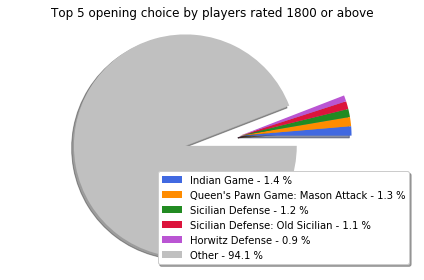

In [13]:
# Extract the first five most used openings and create a pandas Series with these openings 
# as the indexes and their use frequencies as the values. Then append to the end of that
# the use frequencies of all the other openings combined.
other_count = openings_1800_plus.sum() - openings_1800_plus.head().sum()
openings = openings_1800_plus.head().append(pd.Series([other_count], index=["Other"]))
percentages = openings.values/openings.sum() * 100
# Plot the result
plt.pie(openings.values, explode=(0, 0, 0, 0, 0, 0.5), shadow=True, colors=["royalblue", "darkorange", "forestgreen", "crimson", "mediumorchid", "silver"])
plt.legend(labels=['%s - %1.1f %%' % (l, s) for l, s in zip(openings.index, percentages)], loc="lower right", shadow=True)
plt.axis("equal")
plt.title("Top 5 opening choice by players rated 1800 or above")
plt.tight_layout()
plt.show()

From the data above, there seems to be a large divergence in the choice of opening by high-rated players since even the top 5 chosen openings are small fraction of the opening choices. This suggests that there is no best opening. Your choice of opening is dependent on your style of play.

# First move

I have often played 1.e4 and seen that it is one of the most used first moves. I want to check if this is also true for this dataset.

In [14]:
# Function that takes the a string containing all moves separated by spaces and returns the first one
def extract_first_move(moves):
    return moves.split(" ")[0]

In [15]:
# Use pandas apply function to apply the above function to all the elements in the Series containing all the moves in each game
# This returns a new pandas Series
first_moves = chess_df["moves"].apply(extract_first_move)
# Extract the frequency of each move in the above Series
first_moves_frequency = first_moves.value_counts()

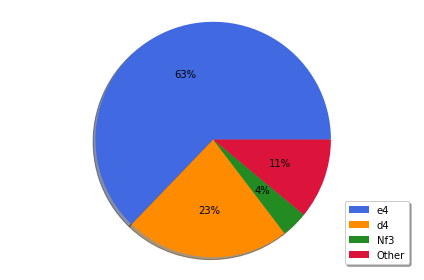

In [16]:
#Plot result
top_3_first_moves = first_moves_frequency.head(3)
other_count = first_moves_frequency.sum() - top_3_first_moves.sum()
first_moves_plt = top_3_first_moves.append(pd.Series([other_count], index=["Other"]))
plt.pie(first_moves_plt.values, shadow=True, autopct="%1.0f%%", colors=["royalblue", "darkorange", "forestgreen", "crimson", "mediumorchid", "silver"])
plt.legend(labels=first_moves_plt.index, loc="lower right", shadow=True)
plt.axis("equal")
plt.tight_layout()
plt.show()

As seen from the result above, 1.e4 is indeed the most popular first move, followed by 1.d4. These two moves combined account for more than 80% of the first moves used by players in this dataset.

# Relationship between player rating and mate/resign rate

I noticed that in some games of more advanced players they resign once they notice that their position in unconquerable while more novice players keep playing till checkmate. I hypothesize that as you increase your skill in chess, you are able to notice when there is no point in keeping the game going. To confirm that, I will analyze the resign rate as rating increases.

In [17]:
# Function that receives a pandas Series containing the winner, rating of both players, and victory status.
# Returns a pandas Series containing only the victory status and the rating of the loser
def extract_rating_of_loser(game):
    loser_rating_and_result = pd.Series([0,game["victory_status"]], index=["rating", "status"])
    if game["winner"] == "white":
        loser_rating_and_result["rating"] = int(game["black_rating"])
    else:
        loser_rating_and_result["rating"] = int(game["white_rating"])
    return loser_rating_and_result

In [18]:
# Extract a pandas Series containing only the rating of the losing player and the result of the game
player_rating_and_result = chess_df[["winner", "white_rating", "black_rating", "victory_status"]].apply(extract_rating_of_loser, axis=1)
# Filter the above pandas Series to contain only mates or resigns
player_rating_and_result = player_rating_and_result[(player_rating_and_result["status"] == "mate") | (player_rating_and_result["status"] == "resign")]

In [21]:
# Group data by status
prr_groupby = player_rating_and_result.groupby("status")

In [32]:
# Separate data into two DataFrames
mate_rating = prr_groupby.get_group("mate")["rating"]
resign_rating = prr_groupby.get_group("resign")["rating"]

In [33]:
print("Mate analysis")
mate_rating.describe()

Mate analysis


count    6325.000000
mean     1471.829723
std       257.987962
min       795.000000
25%      1293.000000
50%      1476.000000
75%      1629.000000
max      2416.000000
Name: rating, dtype: float64

In [34]:
print("Resign analysis")
resign_rating.describe()

Resign analysis


count    11147.000000
mean      1579.182381
std        286.980890
min        784.000000
25%       1384.000000
50%       1562.000000
75%       1784.000000
max       2621.000000
Name: rating, dtype: float64

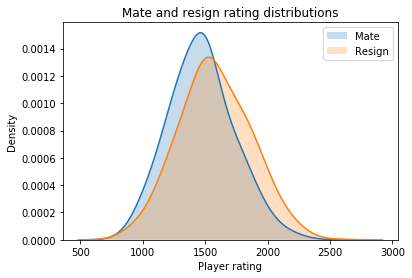

In [67]:
ax = sns.kdeplot(data=mate_rating.values, bw=100, shade=True)
sns.kdeplot(data=resign_rating.values, bw=100, shade=True)
plt.legend(["Mate", "Resign"])
plt.title("Mate and resign rating distributions")
plt.xlabel("Player rating")
plt.ylabel("Density")
plt.show()

Based on the data above, it does not seem to exist a strong relationship between resiging and rating. The mean rating for resign is a little higher (around 100 points), but not enough to be significant. Same with the 1st quartile, mean, and 3rd quartile of both sets.

An interesting observation is that both sets of data seem to be aproximatelly normally distributed.

# Number of turns vs. player rating

Lastly, I would like to know whether there is any relationship between the rating of the players in a chess game and how many turns the game has. I hypothesize that the higher the rating of both players and the more their ratings are close, the longer the game will take.

In [101]:
# Extract a DataFrame with only the relevant data
turns_and_rating = chess_df[["turns", "white_rating", "black_rating"]]

In [109]:
# Get a random sample of the original data (500 chosen so as not to croud the plot too much)
random_sampling = turns_and_rating.sample(n=100)

In [110]:
# Function that finds the plane of best fit.
# If the equation of a plane is ax + by + c = z, then Ax = B
# Solving for x, we get: (A.T * A)^-1 * A.T * B
# Returns a, b, and c as a list
def find_plane_best_fit(x, y, z):
    tmp_A = []
    tmp_b = []
    for i in range(len(x)):
        tmp_A.append([x[i], y[i], 1])
        tmp_b.append(z[i])
    b = np.matrix(tmp_b).T
    A = np.matrix(tmp_A)
    fit = (A.T * A).I * A.T * b
    return fit

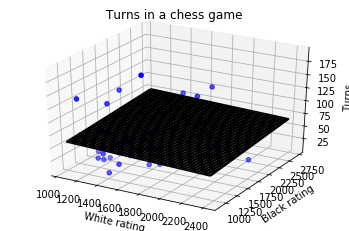

In [121]:
x, y, z = random_sampling["white_rating"].values, random_sampling["black_rating"].values, random_sampling["turns"].values

fit = find_plane_best_fit(x, y, z)

plt.figure()
ax = plt.subplot(111, projection='3d')
ax.scatter(x, y, z, color='b')

xlim = ax.get_xlim()
ylim = ax.get_ylim()
X,Y = np.meshgrid(np.arange(xlim[0], xlim[1]),
                  np.arange(ylim[0], ylim[1]))
Z = np.zeros(X.shape)
for r in range(X.shape[0]):
    for c in range(X.shape[1]):
        Z[r,c] = fit[0] * X[r,c] + fit[1] * Y[r,c] + fit[2]
ax.plot_wireframe(X,Y,Z, color='k')

ax.set_xlabel("White rating")
ax.set_ylabel("Black rating")
ax.set_zlabel("Turns")
plt.title("Turns in a chess game")
plt.show()

From the data above, it seems that the players' rating and the number of turns in the game have nothing to do with each other (the plane is approximately flat).